In [2]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

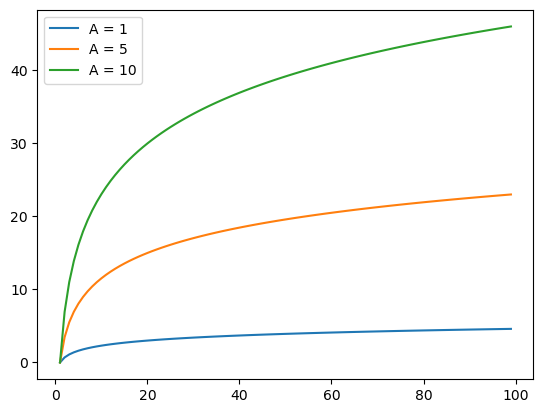

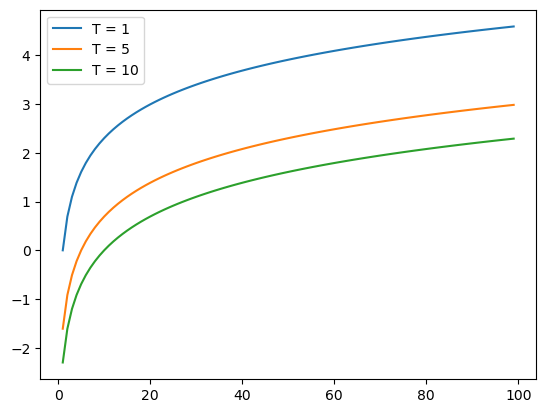

In [15]:
# Simple log function

x = np.arange(1,100,1)
A = [1,5,10]
T = 1

for idx in range(len(A)):
    y = A[idx] * np.log(x/T)
    plt.plot(x, y, label = 'A = ' + str(A[idx]))
    plt.legend()
plt.show()

A = 1
T = [1,5,10]

for idx in range(len(T)):
    y = A * np.log(x/T[idx])
    plt.plot(x, y, label = 'T = ' + str(T[idx]))
    plt.legend()
plt.show()

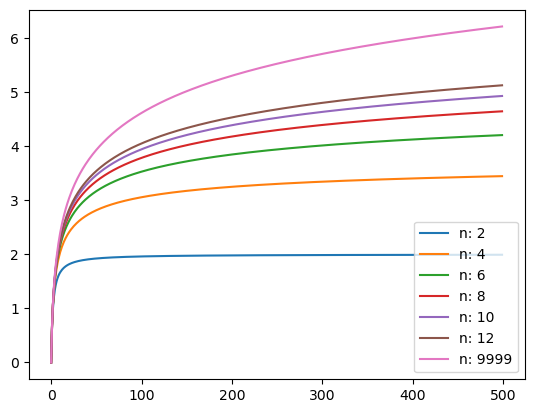

In [95]:
# Montesi power law function, equation 11b

# If the displacement history of the shear zone obeys equation (11b), 
# the GPS signal, which is linearly related to shear zone displacement, 
# follows equation (11b) as well, albeit with modified intensity. 
# In other words, D0 and V0 are modified, but 1/n and τ are preserved. 
# Hence it is possible to invert the GPS signal using equation (11b) to yield an apparent value of 1/n and τ, 
# which may have direct implications for the rheology of the shear zone.

V0 = 1
tau = 1
ns = [2, 4, 6, 8, 10, 12, 9999]
t = np.arange(0,500,1)

for i in range(len(ns)):
    n = ns[i]
    delta = V0 * tau * n * (1 - (1 + (1 - (1/n)) * t/tau)**(1/(1-n)))
    plt.plot(t, delta, label = 'n: ' + str(n))
    plt.legend()

In [87]:
# @as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector]) # input variable types and output variable type(s)
def montesi11b(t, V0, tau, n):
    delta = V0 * tau * n * (1 - (1 + (1 - (1/n)) * t/tau)**(1/(1-n)))
    return delta

In [88]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'
events = pd.read_csv(path + 'events_csv.csv')
snr_array = pd.read_csv(path + 'station_data_hypdists_snrs.csv')
snr_array

Sta      Lat       Lon  Depth(m)  2009_hyp_dist_km  2013_hyp_dist_km  \
0   BCWB  24.2184  121.6891      -192         69.496535         74.182696   
1   TRKB  24.1614  121.6127      -192         61.088805         65.767547   
2   NTTB  24.1728  121.5259      -175         60.587926         65.180780   
3   SJNB  24.1073  121.6006      -193         54.988063         59.668808   
4   HGSB  23.4903  121.4237      -266         15.739505         11.125139   
5   CHMB  23.4868  121.4703      -191         15.969342         11.924641   
6   SSNB  23.4423  121.3981      -185         21.504342         16.833483   
7   ZANB  23.3947  121.4585      -218         26.068219         21.740867   
8   FBRB  23.1406  121.2796      -200         56.994188         52.307853   
9   SSTB  23.1340  121.3782      -199         55.447392         50.858196   
10  DONB  22.9920  121.3124      -181         72.085844         67.442876   

    2018_hyp_dist_km snrs_2009      snrs_2013      snrs_2018  
0           7.066640         -              -              -  
1           9.697232         -  1152.20250487   3719.0718215  
2          18.587874         -              -              -  
3          12.226300         -  1534.07924347  130.500478359  
4          79.319331         -  439.289654937  372.018353576  
5          78.079695         -  348.253341927  40.3376474275  
6          85.224271         -  766.890947625  129.005945014  
7          88.175343         -  3295.27964074  106.461336916  
8         120.756809         -  410.300738921  80.3548941939  
9         118.191393         -  359.179515365  47.0870229521  
10        135.198262         -  88.6580819182              -

## Scipy optimize curve_fit method for power law

In [89]:
from scipy.optimize import curve_fit

2009-10-03_M6.1
2013-10-31_M6.3
Processing TRKB
V0: 0.8285586983664635
tau: 0.6056925680390074
n: 2.16220696530603
15022.355689377335


/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/1085784027.py:3: RuntimeWarning: invalid value encountered in power
  delta = V0 * tau * n * (1 - (1 + (1 - (1/n)) * t/tau)**(1/(1-n)))


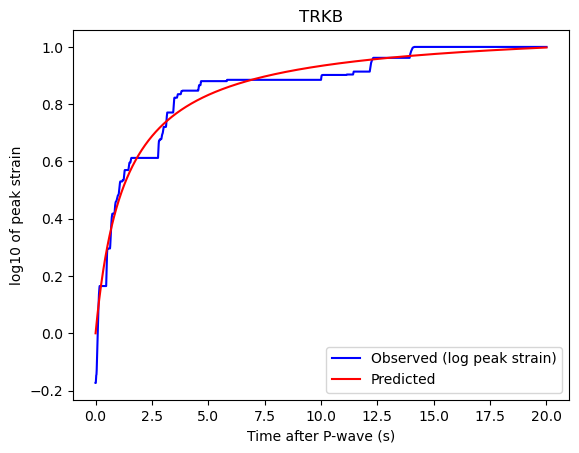

Processing SJNB
V0: 1.1340361009135878
tau: 0.33217072216666216
n: 3.4443479673032655
159632.65204544147


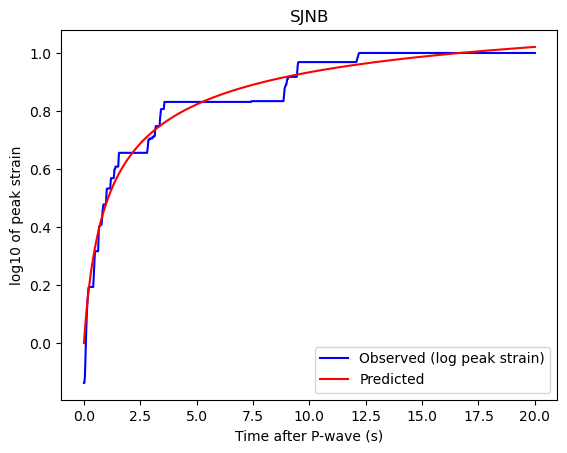

Processing HGSB
V0: 9.999999999999998
tau: 0.036174981636250096
n: 2.920915034406507
246380898.72817367


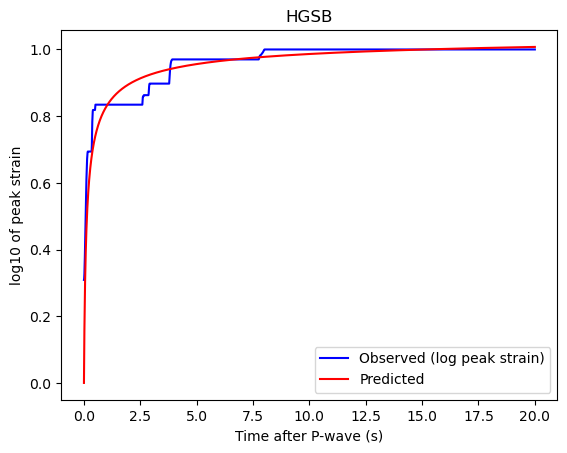

Processing CHMB
V0: 9.999999999974845
tau: 0.02091188273917886
n: 7.33561987013997
1675819402.0660913


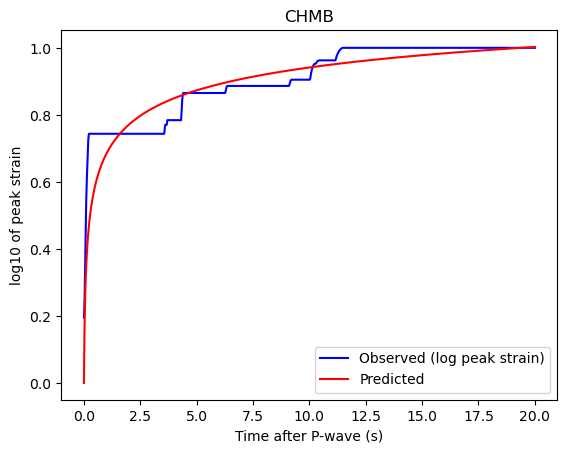

Processing SSNB
V0: 9.999999999999998
tau: 0.024651691027142025
n: 5.320333707929756
835159552.9949551


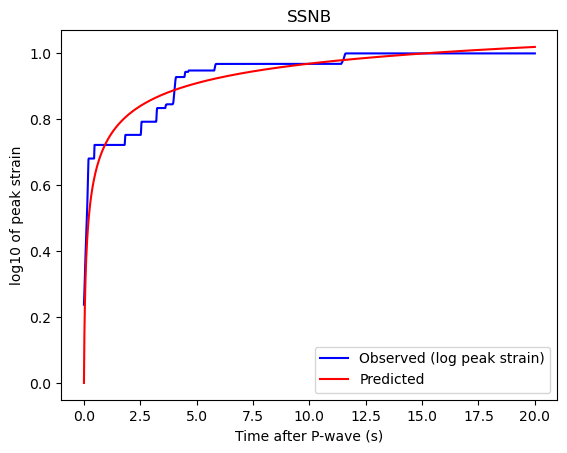

Processing ZANB
V0: 9.999999999999998
tau: 0.019926384492526435
n: 7.855879427420893
2068859666.444173


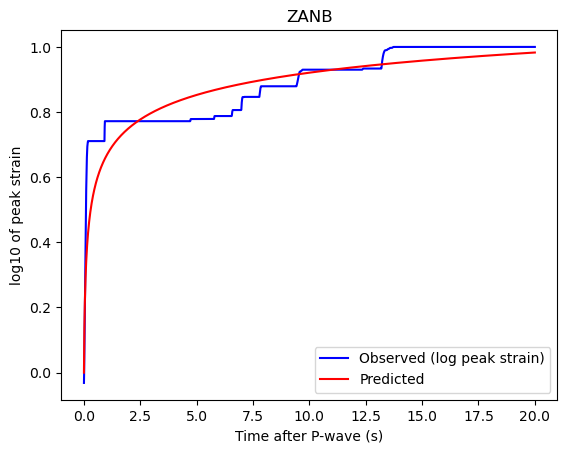

Processing FBRB
V0: 1.2868298408112857
tau: 0.15384431712330413
n: 999.9999999999999
4616139926759587.0


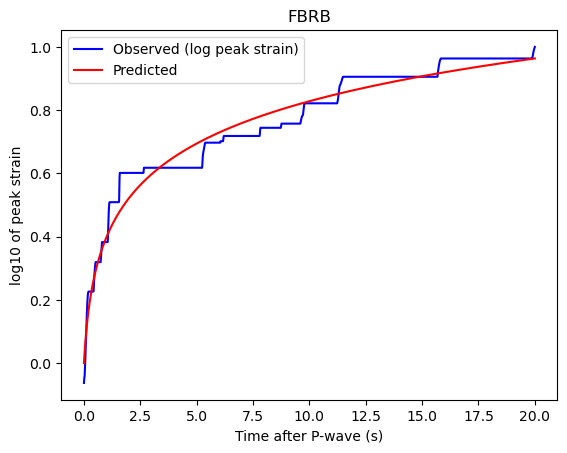

Processing SSTB
V0: 3.9197981940729902
tau: 0.03845590120008616
n: 999.999999942975
5.5876233126396e+16


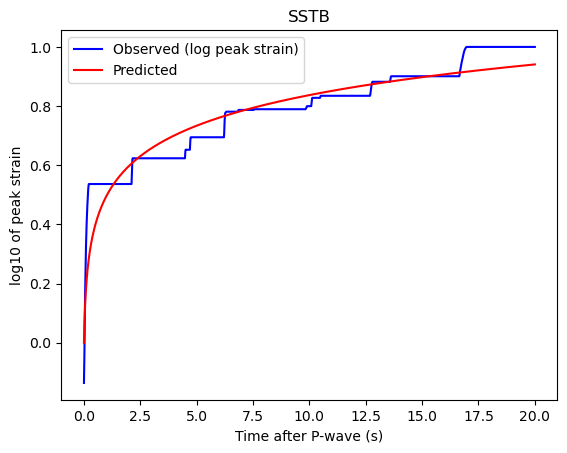

Processing DONB
V0: 0.7826948734739391
tau: 0.2916387984054483
n: 999.9999998532455
1924475933573685.5


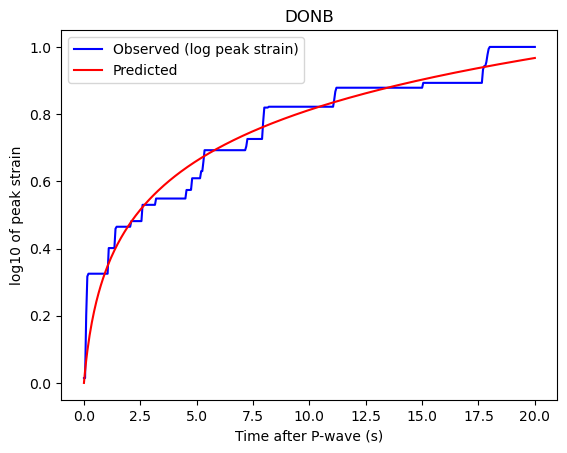

2018-02-04_M6.1


In [97]:
for ii in range(len(events)):
    
    evt_id = events['evt_id'][ii]
    print(evt_id)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        
        if evt_id == '2009-10-03_M6.1':
            hypdist = snr_array['2009_hyp_dist_km'][idx]
        elif evt_id == '2013-10-31_M6.3':
            hypdist = snr_array['2013_hyp_dist_km'][idx]
        elif evt_id == '2018-02-04_M6.1':
            hypdist = snr_array['2018_hyp_dist_km'][idx]
        
        int_hypdist = int(hypdist)

        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        xlow = 10
        xhigh = 20 # For Taiwan
        
        if evt_id == '2013-10-31_M6.3':
            pass
        else:
            continue
        
        try:
            pst = read(path + 'filtered_abs_peak_post_p/' + evt_id + '/' + sta + '.mseed')
        except:
            continue
            
        starttime = pst[0].stats.starttime + xlow
        endtime = starttime + xhigh
        pst_trim = pst.trim(starttime = starttime, endtime = endtime, pad = True, fill_value = 0)

        print('Processing ' + str(sta))

        times = pst_trim[0].times()
        data = pst_trim[0].data
        log10_data = np.log10(data)
        samp_rate = pst_trim[0].stats.sampling_rate

        xobserved = times
        yobserved = log10_data / max(log10_data)

        popt, pcov = curve_fit(montesi11b, xobserved, yobserved, bounds = (0, [10, 10, 1000]))
        
        print('V0: ' + str(popt[0]))
        print('tau: ' + str(popt[1]))
        print('n: ' + str(popt[2]))
        
        print(np.linalg.cond(pcov))

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))

        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)') # ----------------------
        ax.plot(xobserved, montesi11b(xobserved, *popt), color = 'red', label = 'Predicted') # ----------------------
        ax.set_xlabel('Time after P-wave (s)')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()

        plt.show()



## MCMC power law

2009-10-03_M6.1
2013-10-31_M6.3
2013 sta typo BCWB
Processing TRKB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 429 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0         6.554      2.866   2.408     10.036      1.405     1.073       5.0   
tau        0.232      0.236   0.051      0.648      0.118     0.090       4.0   
n      12812.265  23387.502   1.987  60363.416   8915.599  6592.651       5.0   
sigma      0.127      0.024   0.090      0.154      0.012     0.009       5.0   

       ess_tail  r_hat  
V0         16.0   2.86  
tau        11.0   3.24  
n          18.0   2.84  
sigma      25.0   2.31  


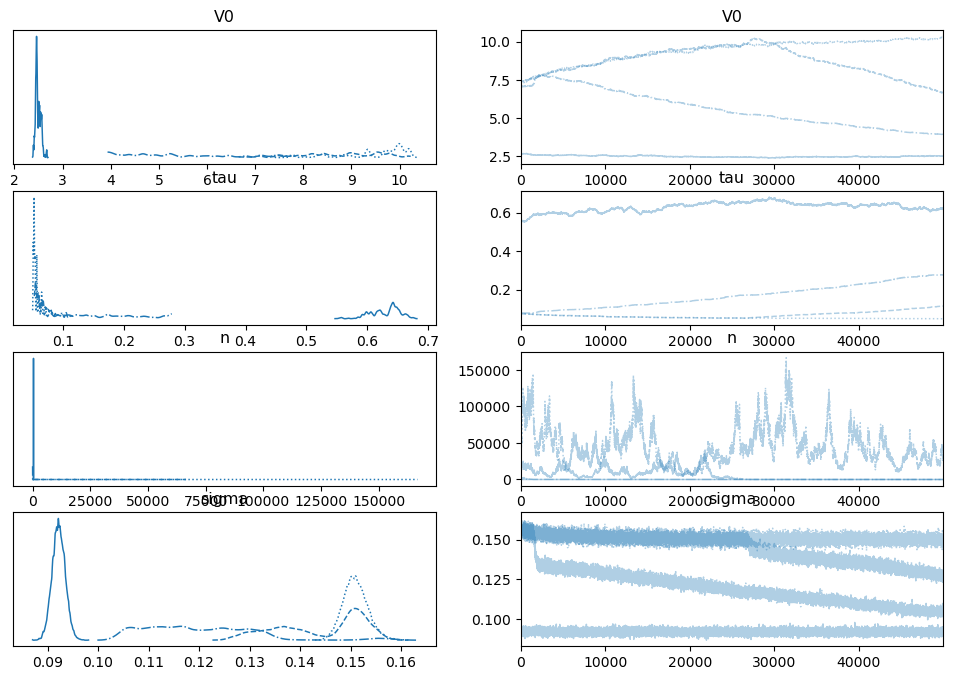

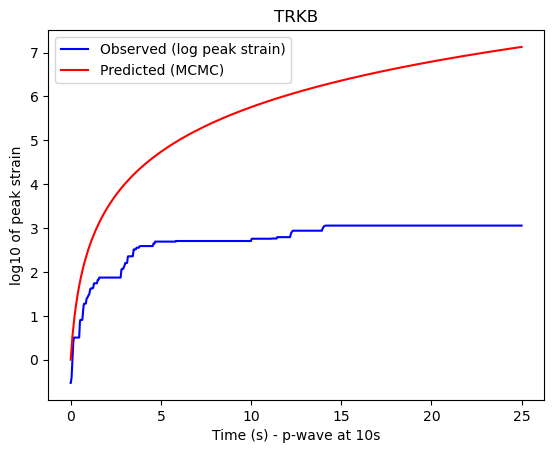

2013 sta typo NTTB
Processing SJNB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 407 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0         8.348      3.086   3.132     11.485      1.512     1.155       5.0   
tau        0.147      0.155   0.044      0.429      0.077     0.059       5.0   
n      30034.874  32459.049   2.594  85861.300  12262.003  9059.458       5.0   
sigma      0.132      0.018   0.100      0.149      0.009     0.007       6.0   

       ess_tail  r_hat  
V0         11.0   2.74  
tau        11.0   2.92  
n          11.0   1.97  
sigma      25.0   1.90  


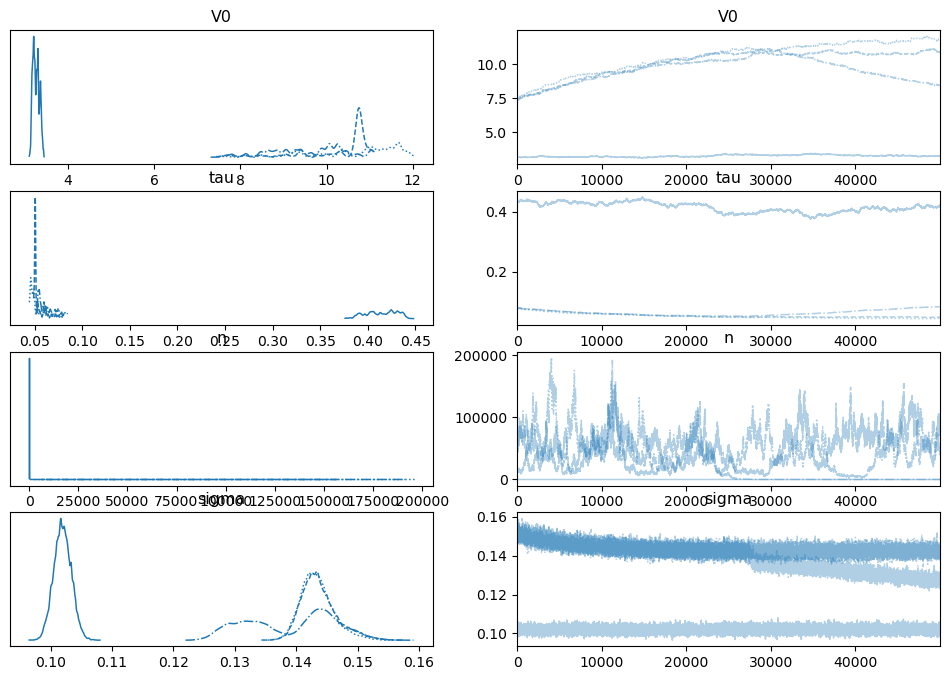

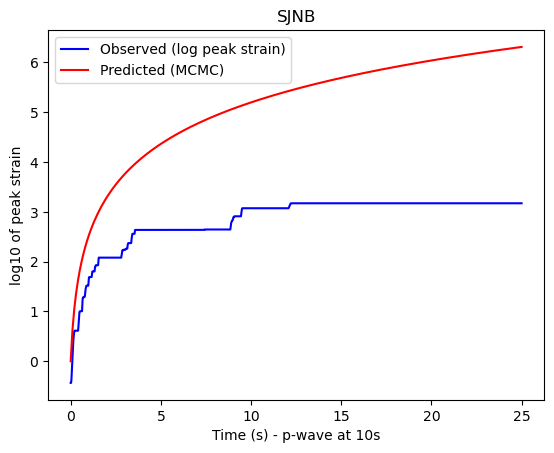

Processing HGSB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 372 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

           mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0       98.148     29.160  45.206    145.915     13.672    10.366       5.0   
tau       0.012      0.010   0.004      0.031      0.005     0.004       4.0   
n      8580.998  22739.500   2.340  56950.412   7059.342  5139.158       5.0   
sigma     0.136      0.071   0.088      0.273      0.028     0.021       9.0   

       ess_tail  r_hat  
V0         11.0   2.36  
tau        11.0   3.34  
n          11.0   3.01  
sigma      30.0   1.46  


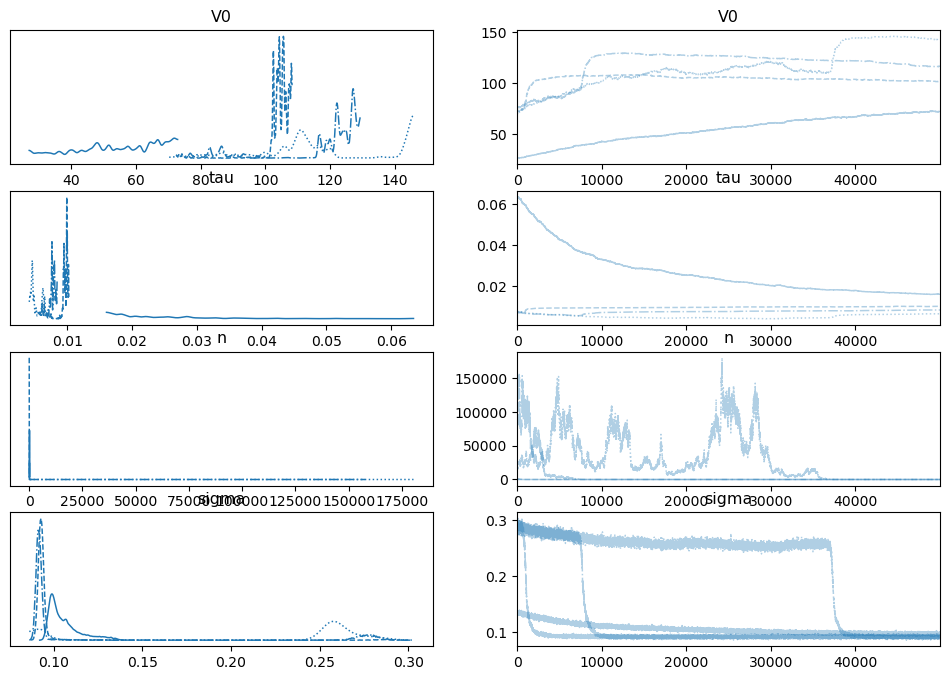

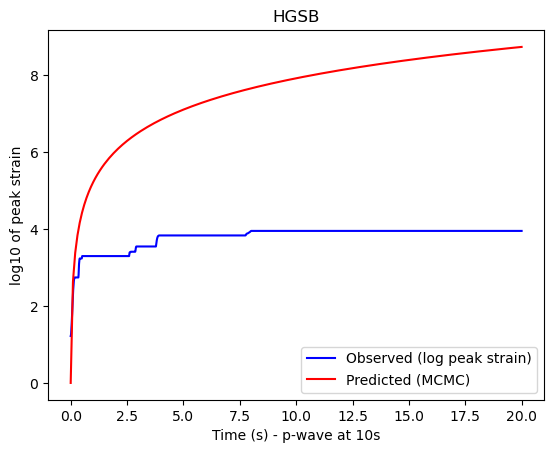

Processing CHMB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 405 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0        61.680     16.732  35.552     87.972      7.514     5.790       5.0   
tau        0.011      0.005   0.005      0.021      0.002     0.002       5.0   
n      14394.091  27094.939   5.302  63816.868   8746.985  6383.449       5.0   
sigma      0.174      0.012   0.156      0.198      0.005     0.004       6.0   

       ess_tail  r_hat  
V0         11.0   2.12  
tau        11.0   2.34  
n          25.0   2.35  
sigma      25.0   1.87  


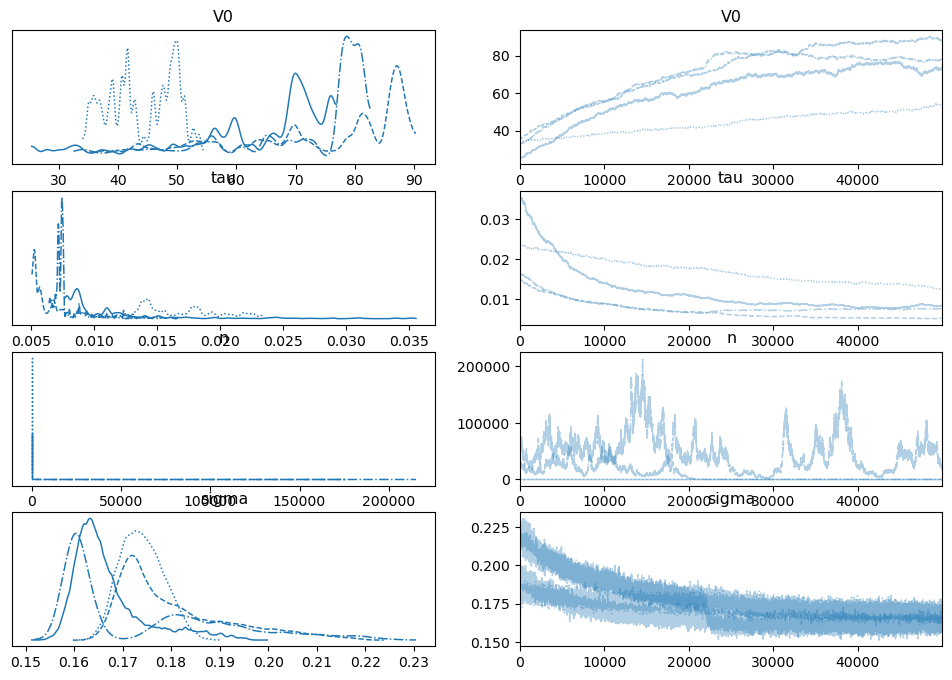

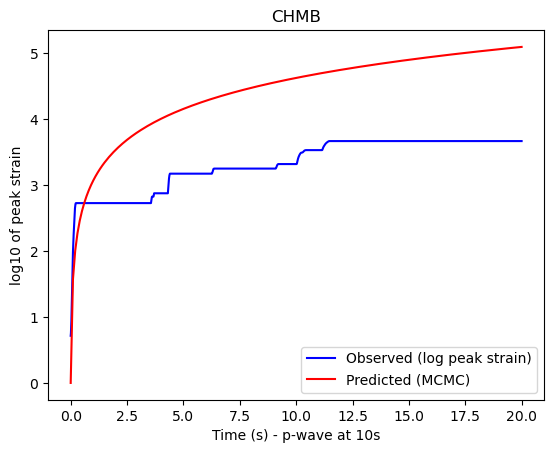

Processing SSNB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 335 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0        71.966     17.104  42.957     97.802      7.467     5.605       6.0   
tau        0.011      0.006   0.006      0.021      0.003     0.002       6.0   
n      14197.436  25812.079   4.041  66376.335   9489.673  6994.095       5.0   
sigma      0.156      0.020   0.134      0.194      0.009     0.006       6.0   

       ess_tail  r_hat  
V0         11.0   1.93  
tau        11.0   1.92  
n          11.0   2.66  
sigma      42.0   1.78  


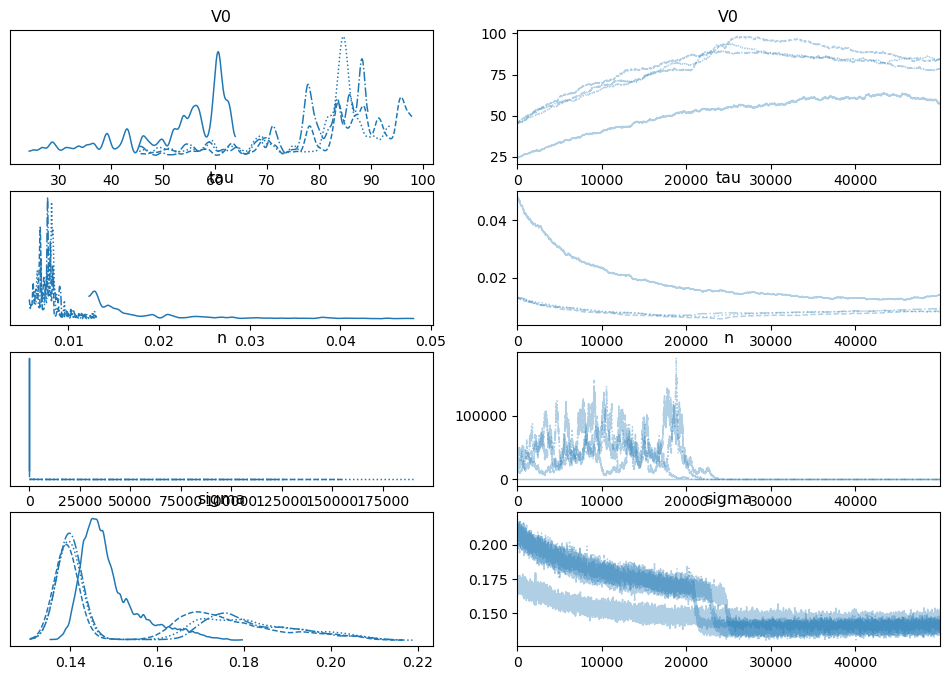

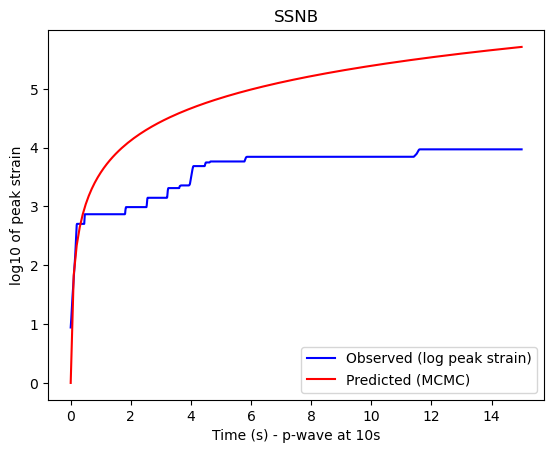

Processing ZANB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 371 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

           mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0       57.646     11.700  33.766     76.885      4.778     3.618       6.0   
tau       0.012      0.004   0.006      0.020      0.002     0.001       6.0   
n      3349.147  14020.621   5.587  13631.182   4253.877  3092.616       5.0   
sigma     0.197      0.009   0.184      0.216      0.003     0.002       8.0   

       ess_tail  r_hat  
V0         18.0   1.74  
tau        20.0   1.90  
n          11.0   2.21  
sigma      22.0   1.46  


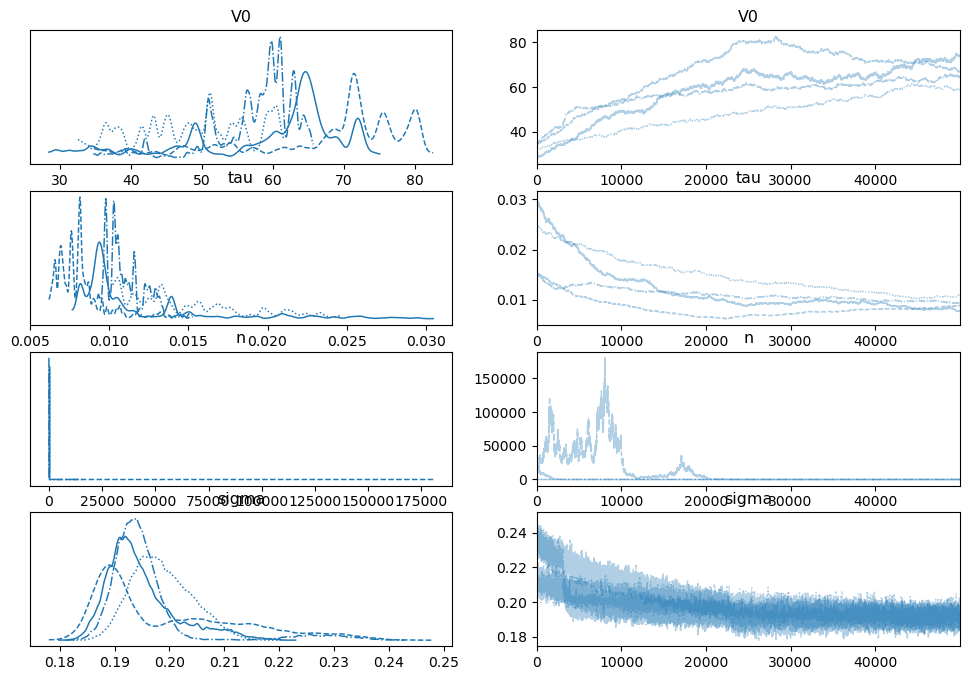

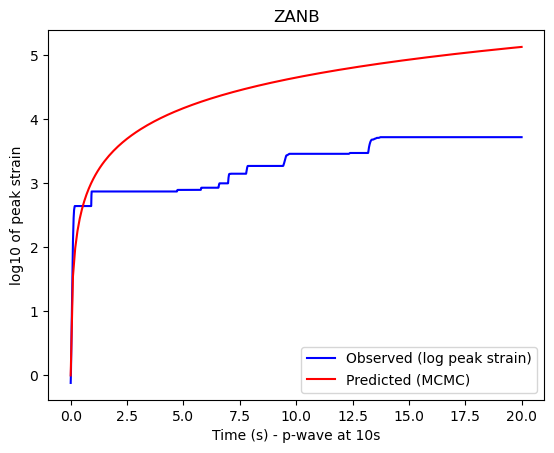

Processing FBRB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 442 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd   hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
V0         2.774      0.104    2.541      2.935      0.038     0.028   
tau        0.258      0.014    0.239      0.289      0.005     0.004   
n      40593.858  29529.712  659.777  93498.481   5450.725  3893.208   
sigma      0.125      0.002    0.122      0.128      0.000     0.000   

       ess_bulk  ess_tail  r_hat  
V0          6.0      32.0   1.68  
tau         6.0      31.0   1.68  
n          25.0      32.0   1.12  
sigma     377.0     767.0   1.01  


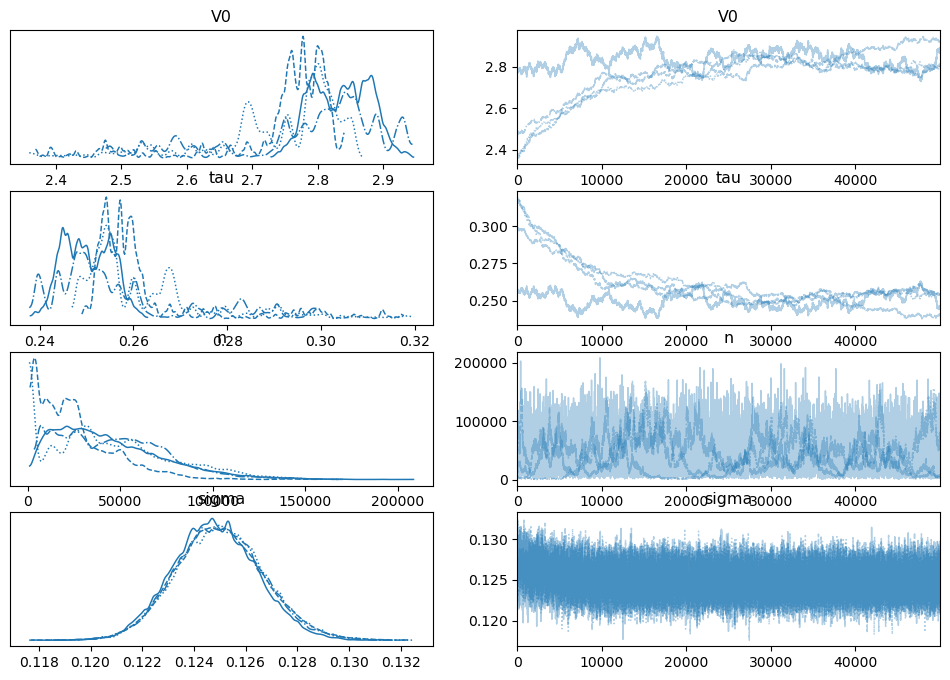

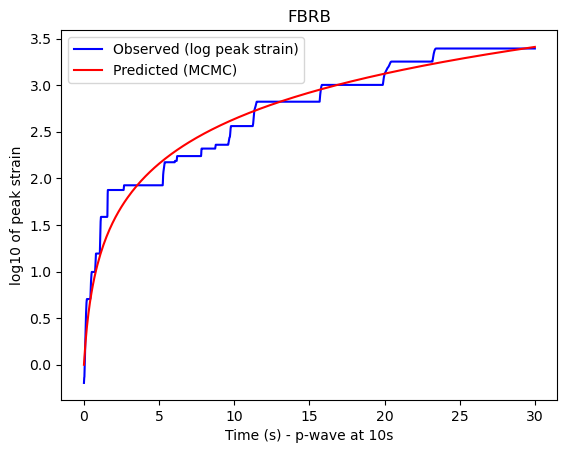

Processing SSTB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 446 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd    hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
V0         6.393      0.751     4.920      7.435      0.326     0.249   
tau        0.090      0.015     0.073      0.121      0.006     0.005   
n      46241.653  28841.066  3646.167  98311.305   2530.959  1793.694   
sigma      0.155      0.003     0.151      0.161      0.001     0.000   

       ess_bulk  ess_tail  r_hat  
V0          5.0      32.0   2.03  
tau         5.0      32.0   2.03  
n         101.0     135.0   1.02  
sigma      20.0      45.0   1.13  


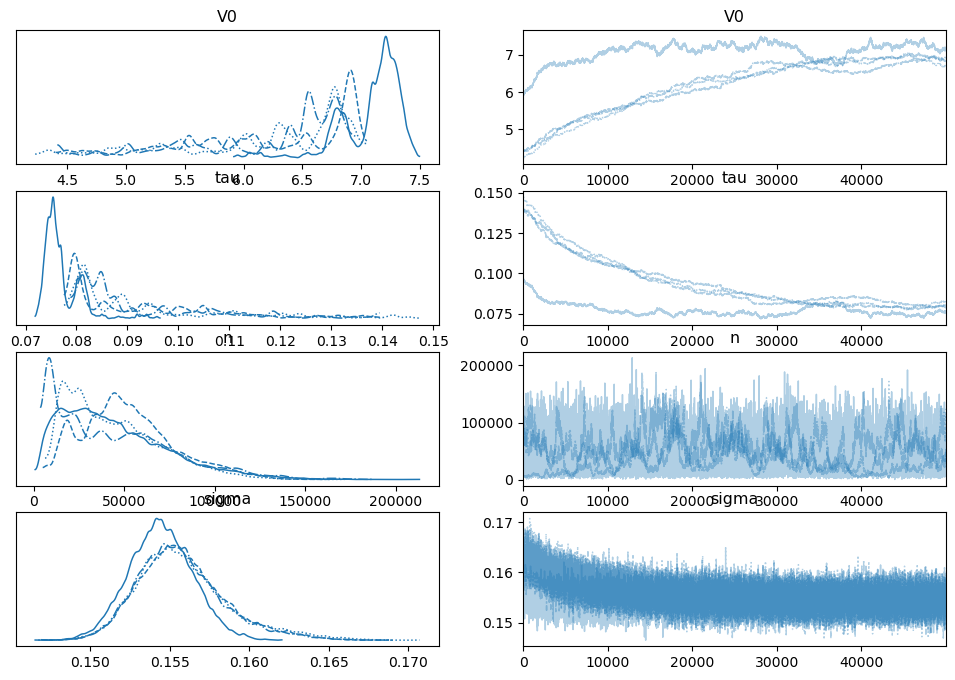

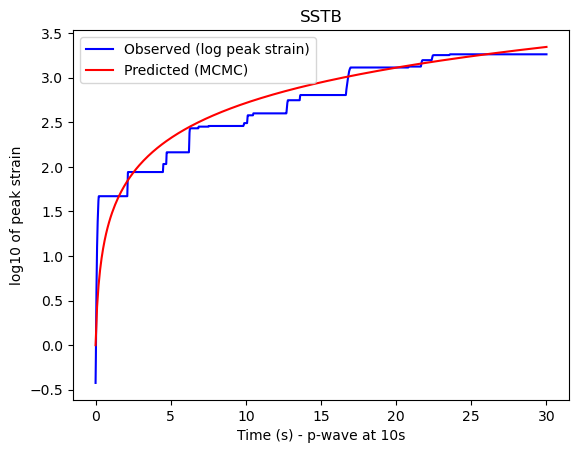

Processing DONB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 277 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd    hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
V0         1.354      0.047     1.262      1.442      0.006     0.004   
tau        0.602      0.030     0.546      0.658      0.003     0.002   
n      35039.491  28089.112  1050.222  88796.143   3508.894  2492.544   
sigma      0.140      0.004     0.133      0.148      0.000     0.000   

       ess_bulk  ess_tail  r_hat  
V0         73.0     145.0   1.03  
tau        73.0     145.0   1.03  
n          55.0     166.0   1.06  
sigma   22258.0   31537.0   1.00  


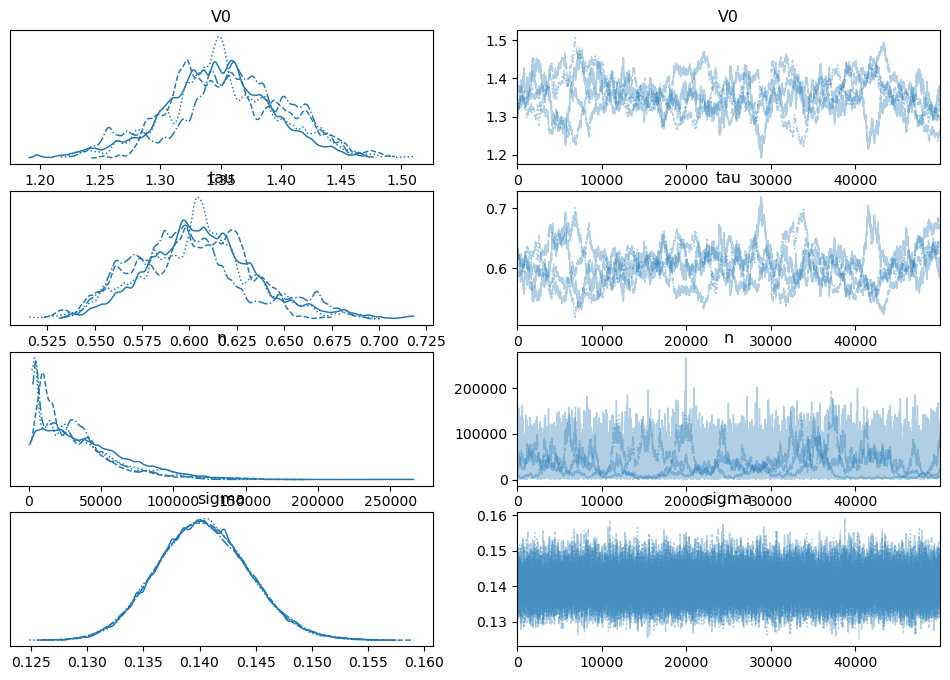

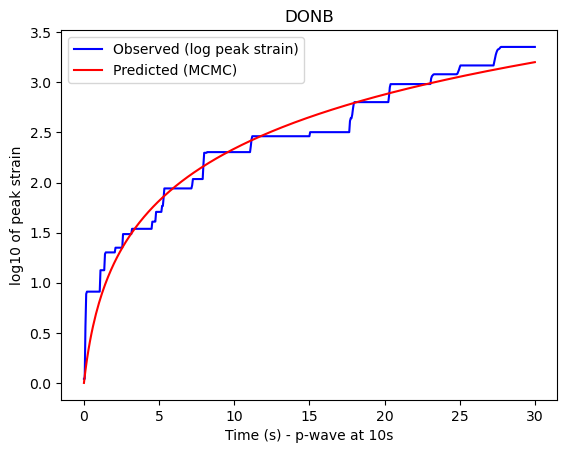

2018-02-04_M6.1
2018 sta typo BCWB
Processing TRKB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 252 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0        23.198     11.381   3.668     33.657      5.581     4.262       7.0   
tau        0.171      0.270   0.011      0.668      0.135     0.103       7.0   
n      32577.787  31377.939   1.022  89321.686  11113.303  8165.195       6.0   
sigma      0.187      0.059   0.080      0.236      0.029     0.022       7.0   

       ess_tail  r_hat  
V0         48.0   1.63  
tau        46.0   1.63  
n          47.0   1.73  
sigma      25.0   1.53  


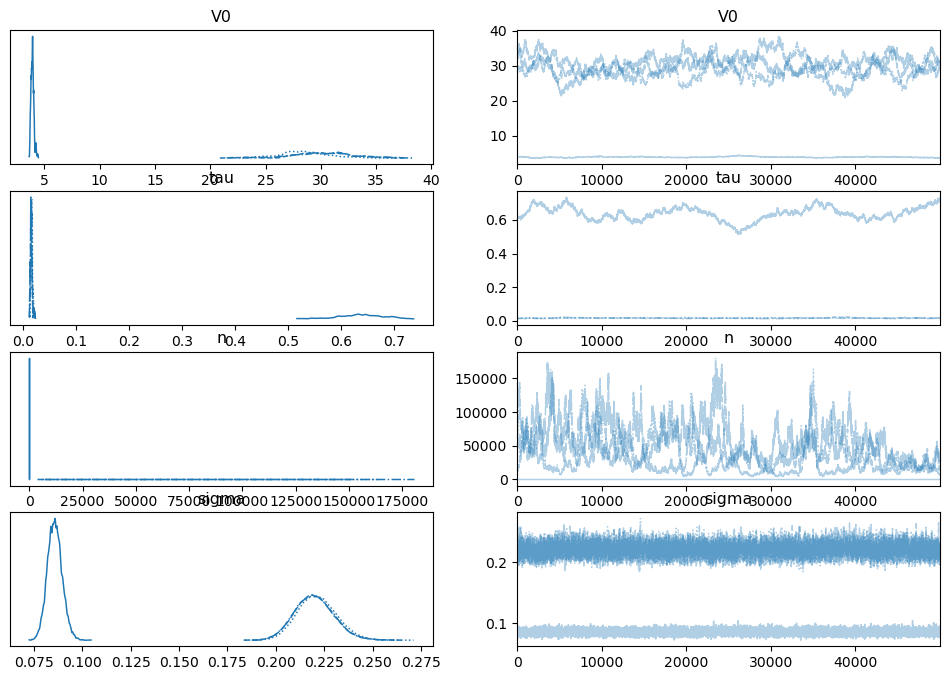

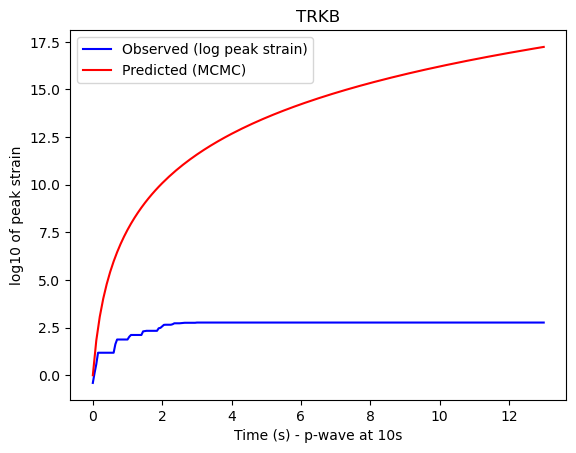

2018 sta typo NTTB
Processing SJNB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 246 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0        15.156      6.798   3.450     21.984      3.308     2.523       7.0   
tau        0.106      0.146   0.016      0.378      0.073     0.056       7.0   
n      34840.600  33575.332   1.684  95427.452   9712.255  7042.548       7.0   
sigma      0.112      0.018   0.078      0.132      0.009     0.007       7.0   

       ess_tail  r_hat  
V0         49.0   1.63  
tau        50.0   1.65  
n          43.0   1.57  
sigma      25.0   1.53  


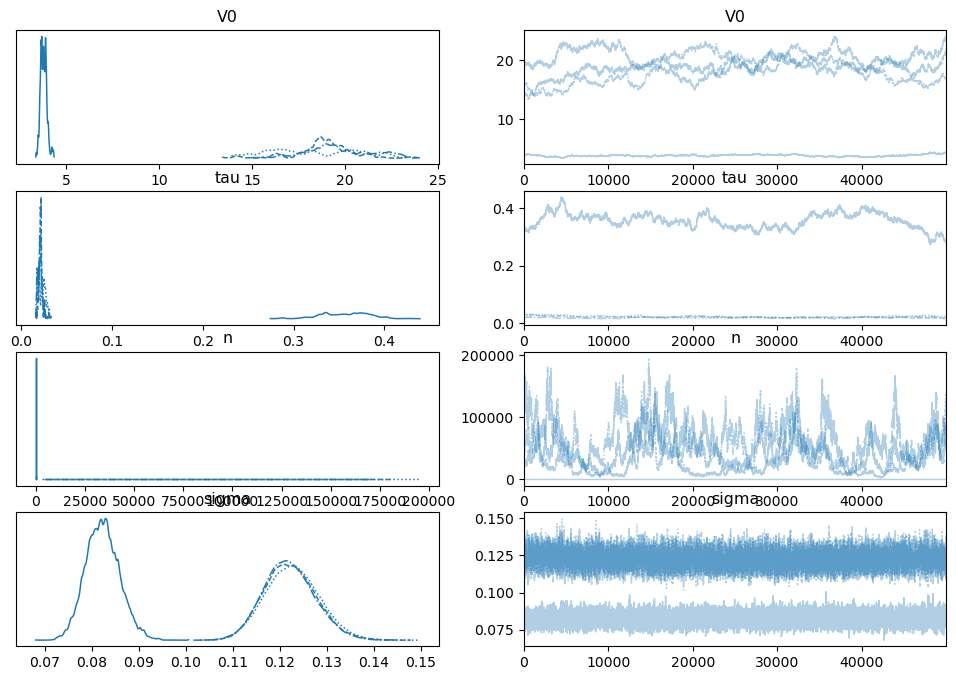

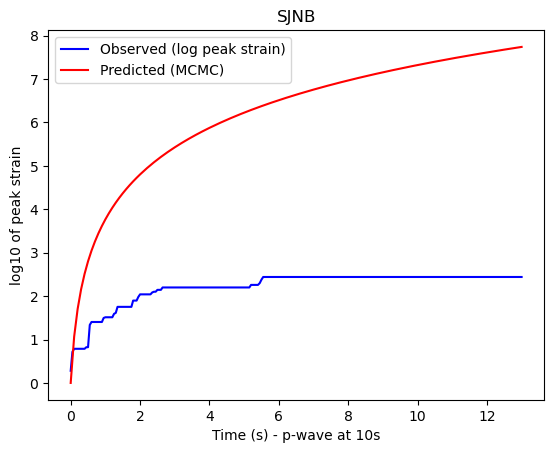

Processing HGSB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 278 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0         2.881      0.731   1.563      3.463      0.363     0.278       6.0   
tau        0.251      0.176   0.137      0.580      0.088     0.067       6.0   
n      21031.084  27648.911   3.455  77980.239   7962.787  5772.661       6.0   
sigma      0.100      0.006   0.089      0.108      0.002     0.002       7.0   

       ess_tail  r_hat  
V0         25.0   1.75  
tau        26.0   1.75  
n          28.0   1.75  
sigma      25.0   1.53  


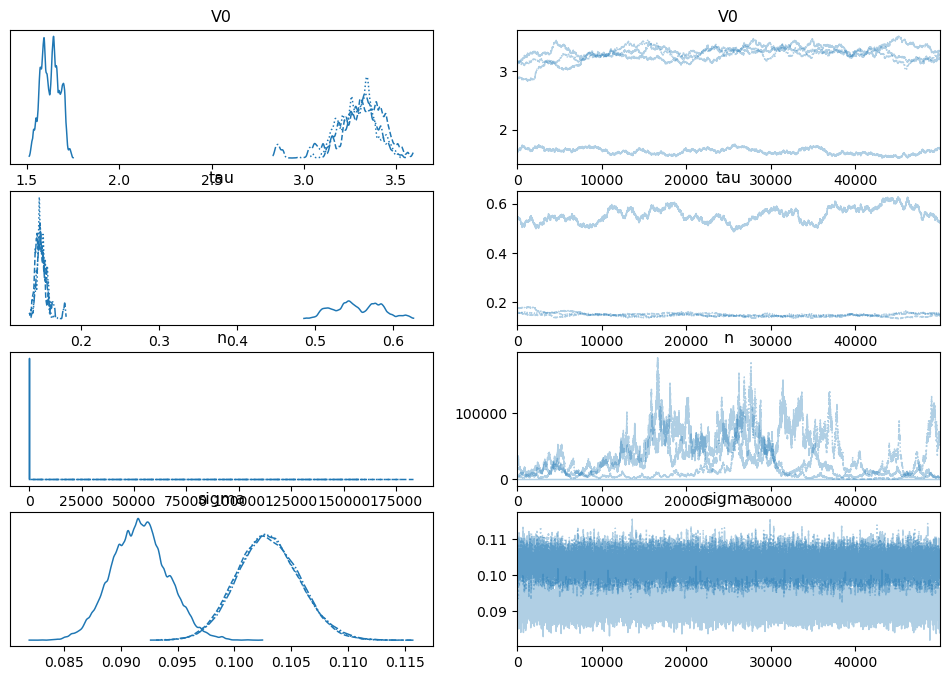

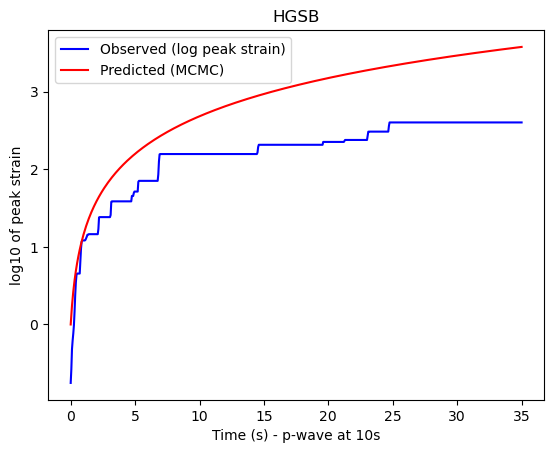

Processing CHMB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 283 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd   hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
V0         0.915      0.026    0.868      0.963      0.004     0.003   
tau        0.673      0.026    0.625      0.723      0.004     0.003   
n      39740.291  29248.419  119.128  92823.523   3301.065  2342.933   
sigma      0.102      0.003    0.097      0.107      0.000     0.000   

       ess_bulk  ess_tail  r_hat  
V0         36.0     154.0   1.09  
tau        36.0     153.0   1.09  
n          62.0      58.0   1.09  
sigma   25648.0   34147.0   1.00  


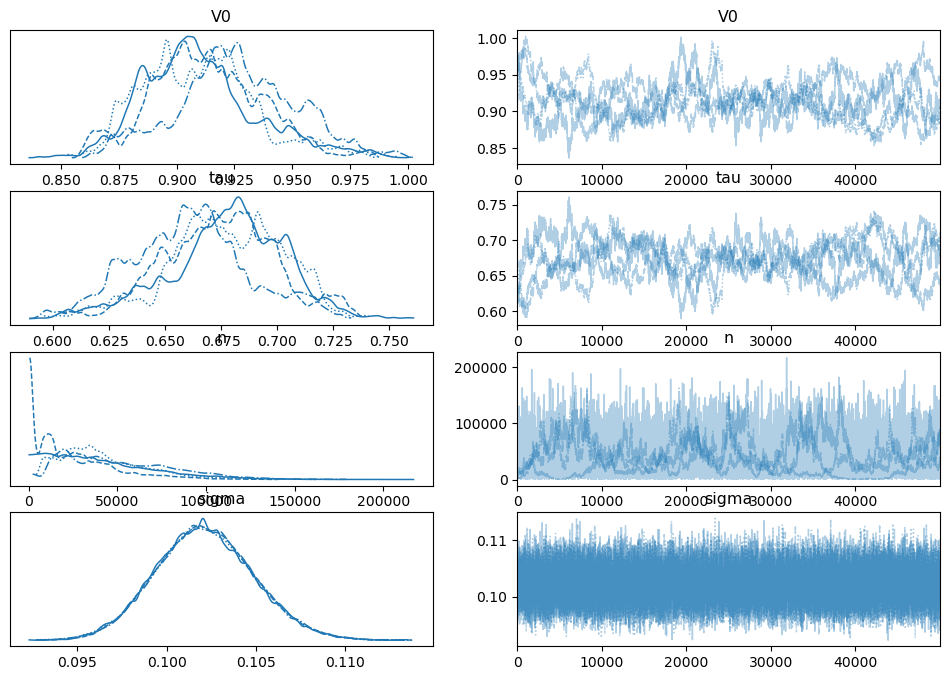

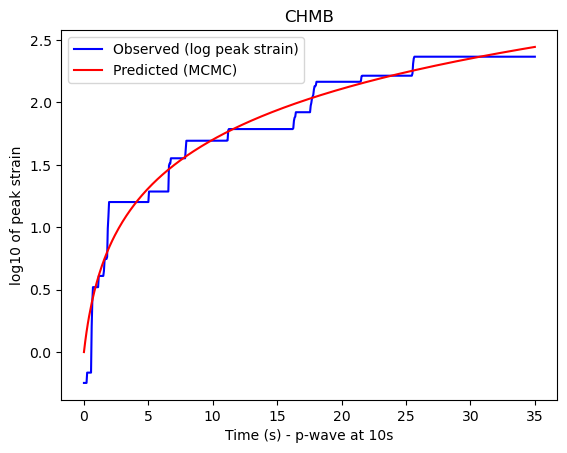

Processing SSNB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 279 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0         1.407      0.083   1.233      1.545      0.037     0.028       6.0   
tau        0.412      0.053   0.354      0.520      0.024     0.018       6.0   
n      33163.993  32643.168   8.627  93905.825   8838.579  6388.553       8.0   
sigma      0.084      0.002   0.080      0.088      0.000     0.000   22393.0   

       ess_tail  r_hat  
V0         11.0   1.68  
tau        11.0   1.68  
n          11.0   1.46  
sigma   33703.0   1.00  


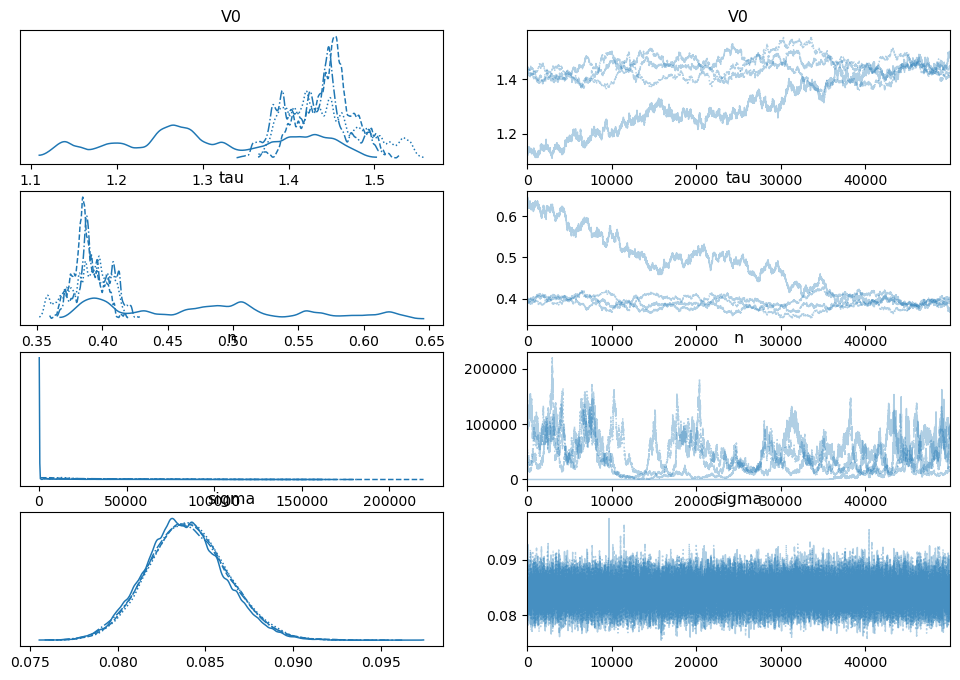

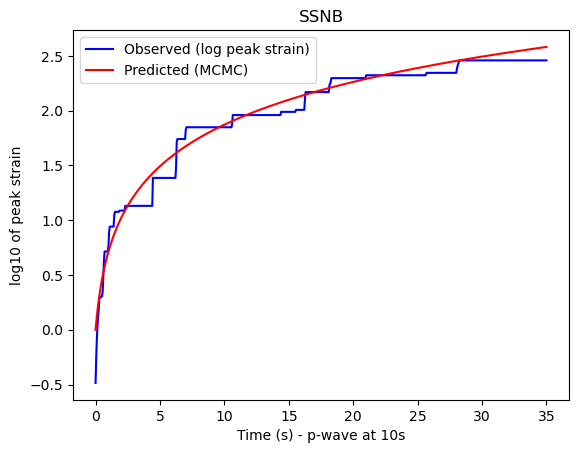

Processing ZANB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 286 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd   hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
V0         2.434      0.150    2.133      2.707      0.035     0.025   
tau        0.191      0.015    0.164      0.222      0.004     0.003   
n      40235.838  29141.465  693.273  92985.132   2968.085  2105.136   
sigma      0.137      0.004    0.130      0.144      0.000     0.000   

       ess_bulk  ess_tail  r_hat  
V0         18.0      85.0   1.16  
tau        18.0      86.0   1.16  
n          82.0      77.0   1.04  
sigma   25238.0   35582.0   1.00  


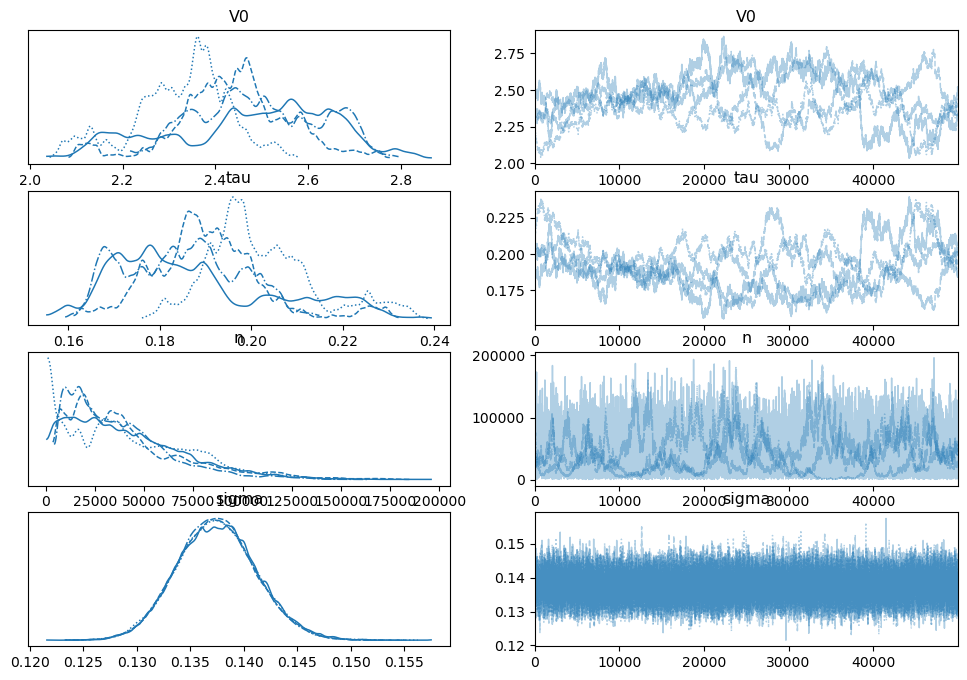

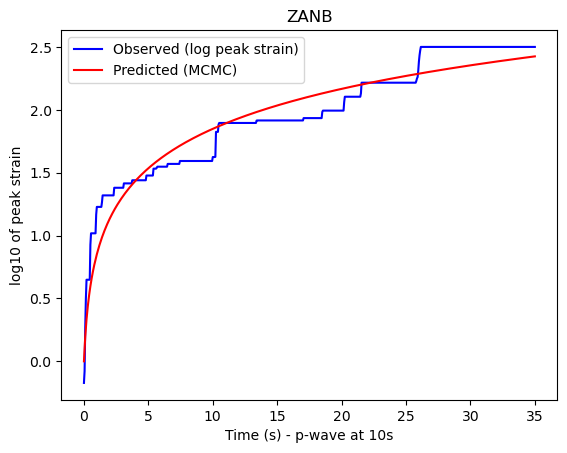

Processing FBRB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 308 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0         0.924      0.121   0.697      1.067      0.058     0.044       6.0   
tau        0.643      0.197   0.450      1.009      0.095     0.072       5.0   
n      24458.492  29880.704   4.860  79592.591  11636.432  8622.360       5.0   
sigma      0.123      0.003   0.117      0.128      0.001     0.000      29.0   

       ess_tail  r_hat  
V0         15.0   2.04  
tau        14.0   2.07  
n          33.0   2.10  
sigma     136.0   1.08  


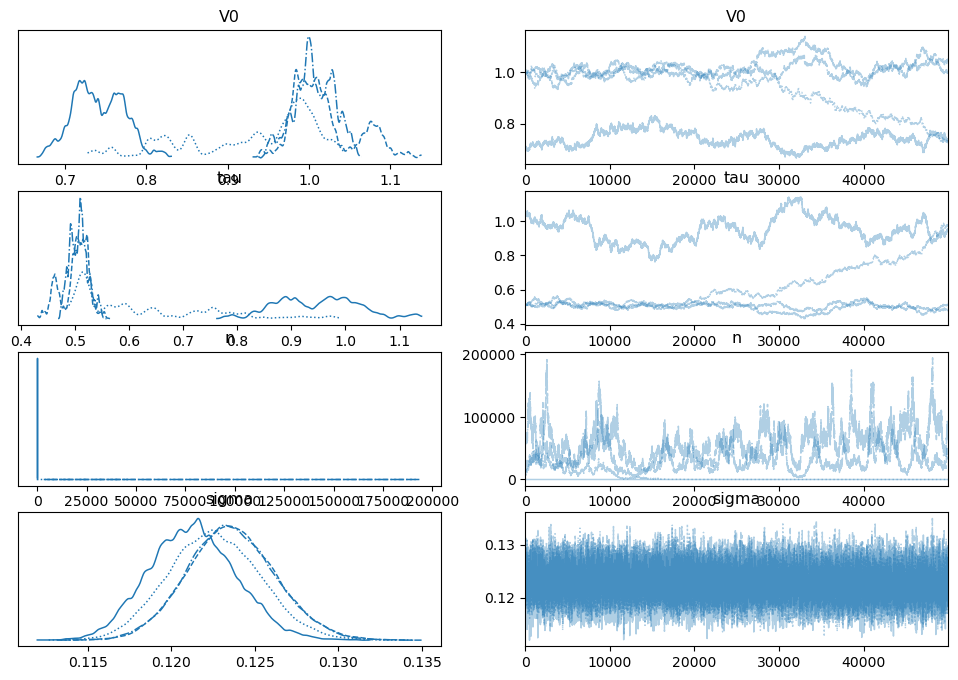

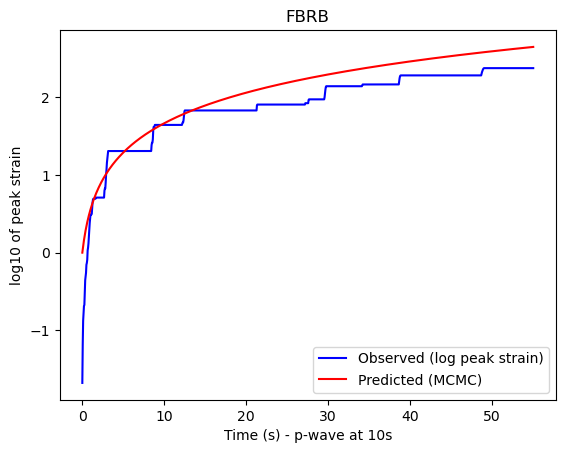

Processing SSTB


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [V0]
>Metropolis: [tau]
>Metropolis: [n]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 309 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  V0 = az.summary(mcmc)['mean'][0]
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_42947/4225359103.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

            mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
V0         4.152      0.696   3.040      5.282      0.315     0.239       5.0   
tau        0.099      0.032   0.066      0.158      0.015     0.011       5.0   
n      23169.827  31392.624   6.773  84765.090  11696.628  8630.874       5.0   
sigma      0.091      0.002   0.087      0.096      0.000     0.000      29.0   

       ess_tail  r_hat  
V0         11.0   2.35  
tau        11.0   2.75  
n          11.0   2.27  
sigma      51.0   1.08  


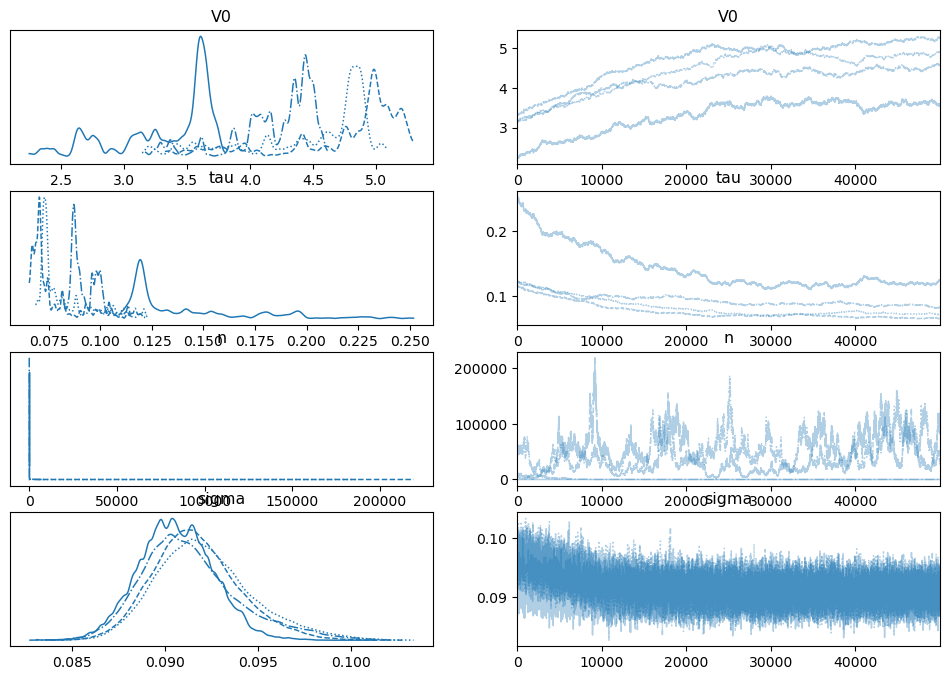

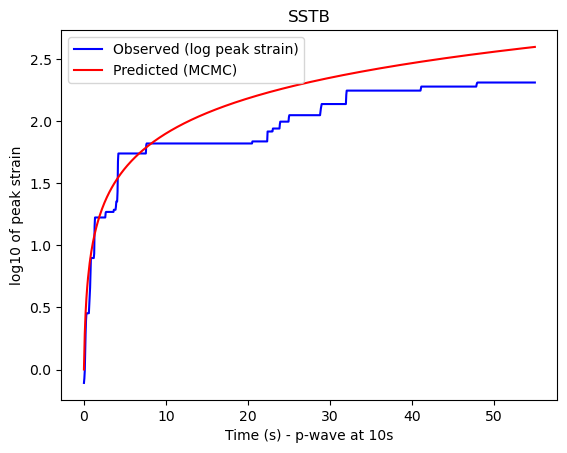

2018 sta typo DONB


In [144]:
for ii in range(len(events)):
    
    evt_id = events['evt_id'][ii]
    print(evt_id)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        
        if evt_id == '2009-10-03_M6.1':
            hypdist = snr_array['2009_hyp_dist_km'][idx]
        elif evt_id == '2013-10-31_M6.3':
            hypdist = snr_array['2013_hyp_dist_km'][idx]
        elif evt_id == '2018-02-04_M6.1':
            hypdist = snr_array['2018_hyp_dist_km'][idx]
        
        int_hypdist = int(hypdist)

        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        xlow = 10
        
        if evt_id == '2009-10-03_M6.1':
            mag = '6.1'
            hypdist = snr_array['2009_hyp_dist_km'][idx]
        elif evt_id == '2013-10-31_M6.3':
            mag = '6.3'
            hypdist = snr_array['2013_hyp_dist_km'][idx]
            if sta == 'FBRB' or sta == 'SSTB' or sta == 'DONB':
                xhigh = 30
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'ZANB':
                xhigh = 20
            elif sta == 'TRKB' or sta == 'SJNB':
                xhigh = 25
            elif sta == 'SSNB':
                xhigh = 15
            else:
                print('2013 sta typo ' + str(sta))
        elif evt_id == '2018-02-04_M6.1':
            mag = '6.1'
            hypdist = snr_array['2018_hyp_dist_km'][idx]
            if sta == 'TRKB' or sta == 'SJNB':
                xhigh = 13
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'SSNB' or sta == 'ZANB':
                xhigh = 35
            elif sta == 'FBRB' or sta == 'SSTB':
                xhigh = 55
            else:
                print('2018 sta typo ' + str (sta))
        
        int_hypdist = int(hypdist)
        
        # if evt_id == '2013-10-31_M6.3' and sta == 'SSTB':
        #     pass
        # else:
        #     continue
        
        try:
            pst = read(path + 'filtered_abs_peak_post_p/' + evt_id + '/' + sta + '.mseed')
        except:
            continue

        print('Processing ' + str(sta))
        
        starttime = pst[0].stats.starttime + xlow
        endtime = starttime + xhigh
        pst_trim = pst.trim(starttime = starttime, endtime = endtime, pad = True, fill_value = 0)

        times = pst_trim[0].times()
        data = pst_trim[0].data
        log10_data = np.log10(data)
        samp_rate = pst_trim[0].stats.sampling_rate

        xobserved = times
        yobserved = log10_data

        # In order to pass the x variable into the target function it needs to be converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)

        # MCMC run parameters, these are good numbers for a "production" run. If you are fooling arund these can be lower to iterate faster
        Nburn = 10000 # burn in samples that get discarded
        Nmcmc = 50000 # bump to at least 5-10k - increase this after ficing the uniform part 
        Nchains = 4
        Ncores = 1

        # Define the Bayesian model
        with pm.Model() as model:
            
            # Priors for unknown model parameters
            V0 = pm.HalfNormal('V0', sigma = 5)
            tau = pm.HalfNormal('tau', sigma = 5)
            n = pm.HalfNormal('n', sigma = 50000)
            sigma = pm.HalfCauchy('sigma', beta = 10) # Observation error
            
            # Expected value of outcome - the function we're trying to fit
            mu = montesi11b(pt_xobserved, V0, tau, n) 
            # print(mu)

            # This is the model - likelihood (sampling distribution) of observations in dataset
            likelihood = pm.Normal('y', mu = mu, observed = yobserved, sigma = sigma) # Normal distribution with a mean that is the y_out array?

            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis(scaling = 0.025) # Check out Diego's book - condition for accepting new sample as "better" than last

            # This runs the MCMC sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)

        # Done, now is post-processing to get the data out of the sampler
        # posterior = az.extract(mcmc)
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        
        V0 = az.summary(mcmc)['mean'][0]
        tau = az.summary(mcmc)['mean'][1]
        n = az.summary(mcmc)['mean'][2]
        
        ypredicted = V0 * tau * n * (1 - (1 + (1 - (1/n)) * xpredicted/tau)**(1/(1-n)))
        
        # Summary
        print(az.summary(mcmc))
        
        az.plot_trace(mcmc)
        plt.show()
        # plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
        # plt.close()

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))

        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)') # ----------------------
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)') # ----------------------
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()

        plt.show()



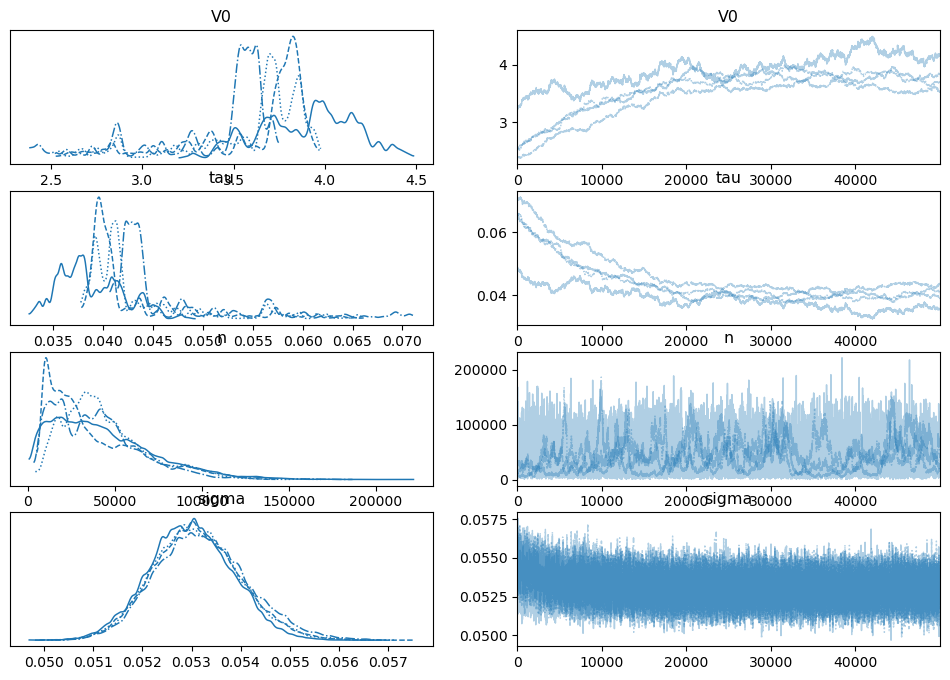

In [143]:
az.plot_trace(mcmc);